In [1]:
import numpy as np

def fourier_series_coeffs(func, T=1.0, M=32, N=None, x0=0.0):
    """
    フーリエ求数
        f(x) ≈ Σ_{k=-M..M} c_k exp(-2π i k x / T)
    の係数を計算する

    Args:
        func : callable, 複素値可。ベクトル化推奨。
        T    : 周期
        M    : 取り出す最大次数（-M..M）
        N    : サンプル数（既定は 2*M+1（奇数））
        x0   : サンプリング開始点（位相補正により c_k は開始点に依存しない形で返す）
    
    Returns:
        ks (整数配列): kのリスト
        cs (複素係数配列): 係数c_kのリスト
        meta dict
    """
    if N is None:
        N = 2*M + 1  # 推奨：奇数 → kがちょうど -M..M
    if M > N//2:
        raise ValueError("M は N/2 以下にしてください。")

    # 等間隔サンプリング（1周期）
    ns = np.arange(N)
    xs = x0 + (T * ns / N)
    fs = np.asarray(func(xs), dtype=complex)

    # DFT → 係数（Riemann和より c_k ≈ (1/N) Σ f_n e^{-2π i k n/N}）
    F = np.fft.fft(fs) / N          # k=0..N-1
    Fc = np.fft.fftshift(F)        # k を中心化

    # 対応する整数 k 配列
    if N % 2 == 1:
        k_all = np.arange(-(N//2), N//2 + 1)   # 例: N=2M+1 → -M..M
    else:
        k_all = np.arange(-N//2, N//2)         # 偶数の場合

    # サンプリング開始 x0 の位相補正（基底は x に対する e^{-2π i k x/T}）
    phase = np.exp(2j * np.pi * k_all * (x0 / T))
    c_all = Fc * phase

    # -M..M を抽出
    pick = (k_all >= -M) & (k_all <= M)
    ks = k_all[pick]
    cs = c_all[pick]
    return ks, cs, {"T": T, "M": M, "N": N, "x0": x0}

def fourier_series_eval(xs, ks, cs, T):
    xs = np.asarray(xs)
    return np.sum(cs[:, None] * np.exp(-2j * np.pi * ks[:, None] * (xs / T)), axis=0)

def periodic_extension(f_base, L):
    return lambda x: f_base(((np.asarray(x)+L) % (2*L)) - L)



In [2]:
# ガウス関数
sigma = 1.0
func = lambda x: 1/np.sqrt(sigma) * np.exp(-x*x / (2*sigma*sigma))

# フーリエ求数計算
# サンプリング範囲 = (-np.pi, +np.pi)を10点
T = 2 * np.pi
x0 = -T/2
N = 10
# フーリエ求数は [+M,...,-M]の範囲
M = 2

# フーリエ係数の決定と量子状態へのエンコーディング
ks, cs, _ = fourier_series_coeffs(func, x0=-T/2, T=T, M=M, N=N)

In [20]:

def build_c_tilde_amplitudes_from_ck(ks, cs, m=None):
    """
    フーリエ係数 {c_k} から |c̃> の非正規化振幅ベクトルを構成する。

      |c̃> = Σ_{k=0..M} c_k |k>
           + Σ_{k=1..M} c_{-k} |2^{m+1}-k>

    （全体スケール 2^{n/2} は無視）

    Returns
    -------
        amps : complex ndarray, shape (2^{m+1},)
        meta : dict {"M": M, "m": m, "dim": 2^{m+1}, "n_qubits": m+1}
    """
    ks = np.asarray(ks, dtype=int)
    cs = np.asarray(cs, dtype=complex)

    if ks.shape != cs.shape:
        raise ValueError("ks と cs の長さが一致していません。")

    M = int(np.max(np.abs(ks)))
    if M <= 0:
        raise ValueError("M <= 0 です。非自明なフーリエ級数になっていません。")

    # m 未指定なら 2^{m+1} >= 2M+1 となる最小 m
    if m is None:
        m = int(np.ceil(np.log2(2*M + 1))) - 1

    dim = 1 << (m + 1)        # 2^{m+1}
    n_qubits = m + 1

    coeff = {int(k): c for k, c in zip(ks, cs)}
    amps = np.zeros(dim, dtype=complex)

    # 第1項: Σ_{k=0..M} c_k |k>
    for k in range(0, M + 1):
        if k in coeff:
            if not (0 <= k < dim):
                raise ValueError(f"k={k} が次元 {dim} の範囲外です。m を大きくしてください。")
            amps[k] += coeff[k]

    # 第2項: Σ_{k=1..M} c_{-k} |2^{m+1}-k>
    for k in range(1, M + 1):
        if -k in coeff:
            idx = dim - k  # 2^{m+1} - k
            if not (0 <= idx < dim):
                raise ValueError(
                    f"2^(m+1)-k = {idx} が次元 {dim} の範囲外です。m の計算ロジックを確認してください。"
                )
            amps[idx] += coeff[-k]

    meta = {"M": M, "m": m, "dim": dim, "n_qubits": n_qubits}
    return amps, meta

In [15]:
def _apply_rz_on_pair(a0, a1, alpha):
    """ターゲット qubit に Rz(alpha) が作用したときの (a0,a1) 変換"""
    phase0 = np.exp(-0.5j * alpha)
    phase1 = np.exp(+0.5j * alpha)
    return phase0 * a0, phase1 * a1


def _apply_ry_on_pair(a0, a1, beta):
    """ターゲット qubit に Ry(beta) が作用したときの (a0,a1) 変換"""
    c = np.cos(beta / 2.0)
    s = np.sin(beta / 2.0)
    b0 = c * a0 - s * a1
    b1 = s * a0 + c * a1
    return b0, b1


def _index_pair_for_target(dim, t):
    """
    dim=2^n, t はターゲット qubit (0=LSB)。
    各「他ビットのパターン」について (idx0, idx1) のペアを列挙。
    """
    n = int(np.log2(dim))
    assert dim == (1 << n)
    pairs = []
    for base in range(dim):
        if (base >> t) & 1:
            continue  # bit_t=1 側はスキップ
        idx0 = base
        idx1 = base | (1 << t)  # bit_t を 1 にしたインデックス
        pairs.append((idx0, idx1))
    return pairs

def _su2_angles_for_pair(a0, a1, eps=1e-14):
    """
    2 成分 (a0, a1) を (r, 0) に潰すために必要な
    U^{dagger} = Ry(-θ) Rz(-φ) の θ, φ を計算する。
    （戻り値は θ, φ）

    戻り値:
        theta, phi
    """
    r = np.sqrt(abs(a0)**2 + abs(a1)**2)
    if r < eps:
        # ほぼ (0,0) => 何もしない
        return None, None

    s0 = a0 / r
    s1 = a1 / r
    mag0 = abs(s0)
    mag1 = abs(s1)

    if mag1 < eps:
        # ほぼ |0> （すでに (1,0) up to phase）
        theta = 0.0
        phi = 0.0
        return theta, phi

    if mag0 < eps:
        # ほぼ |1> 状態: Rz(φ)Ry(π)|0> = e^{i*} |1>
        theta = np.pi
        phi = 2.0 * np.angle(s1)
        return theta, phi

    # 一般ケース
    theta = 2.0 * np.arccos(mag0)          # cos(θ/2) = |s0|
    phi = np.angle(s1) - np.angle(s0)      # 相対位相
    return theta, phi

In [16]:
def synthesize_state_unprep_ops(amps_in, eps=1e-14):
    """
    |ψ> = amps_in から |0...0> への変換 U† を、
    多重制御 Rz, Ry のカスケードとして設計し、
    その「操作リスト」と、最終的に得られた状態ベクトルを返す。

    戻り値:
        ops : list of dict
            各要素は {
                "target": int,
                "controls": [qubit indices],
                "ctrl_vals": [0/1],
                "alpha": float,  # Rz(alpha) を先に
                "beta": float,   # 次に Ry(beta)
            }
            という U† 側のパラメータ
        final_vec : ndarray
            U† を適用した後の状態（理想的には |0...0>）
    """
    vec = np.asarray(amps_in, dtype=complex).copy()
    dim = vec.size
    n = int(np.log2(dim))
    if dim != (1 << n):
        raise ValueError("ベクトル長は 2^n である必要があります。")

    ops = []

    # ターゲット qubit を 0,1,2,... と順に消していく
    for t in range(n):
        pairs = _index_pair_for_target(dim, t)
        for idx0, idx1 in pairs:
            a0, a1 = vec[idx0], vec[idx1]
            theta, phi = _su2_angles_for_pair(a0, a1, eps=eps)
            if theta is None:
                continue  # 何もする必要なし

            # U† = Ry(-θ) Rz(-φ) を実際に適用：
            # Rz(-φ), Ry(-θ) の順で vec を更新
            alpha = -phi
            beta = -theta

            # Rz(alpha)
            a0_rz, a1_rz = _apply_rz_on_pair(a0, a1, alpha)
            # Ry(beta)
            b0, b1 = _apply_ry_on_pair(a0_rz, a1_rz, beta)

            vec[idx0] = b0
            vec[idx1] = b1

            # 制御条件（他の全 qubit をコントロールにする）
            controls = [q for q in range(n) if q != t]
            ctrl_vals = [ (idx0 >> q) & 1 for q in controls ]

            ops.append({
                "target": t,
                "controls": controls,
                "ctrl_vals": ctrl_vals,
                "alpha": alpha,
                "beta": beta,
            })

    return ops, vec


In [17]:
from qulacs import QuantumCircuit
from qulacs.gate import RY, RZ, to_matrix_gate

def build_Uc_circuit_from_ck_cascade(ks, cs, m=None, eps=1e-14):
    """
    {c_k}（負インデックス含む）から
      |c̃> = Σ_{k>=0} c_k |k> + Σ_{k>=1} c_{-k} |2^{m+1}-k>
    を定義どおりに構成し、その |0...0> -> |c̃> を行う
    状態準備回路 U_c を

      「多重制御 Rz, Ry のカスケード（uniformly-controlled rotations）」

    として Qulacs QuantumCircuit で返す。

    戻り値:
        circuit : QuantumCircuit
        meta    : dict (M, m, dim, n_qubits など)
    """
    # 1) 振幅ベクトルを組み立て
    amps, meta = build_c_tilde_amplitudes_from_ck(ks, cs, m=m)
    dim = meta["dim"]
    n_qubits = meta["n_qubits"]

    # 2) 正規化
    norm = np.linalg.norm(amps)
    if norm < eps:
        raise ValueError("得られた |c̃> のノルムが 0 に近すぎます。")
    amps_norm = amps / norm

    # 3) U† のカスケードを設計（ops: U† の順番）
    ops, final_vec = synthesize_state_unprep_ops(amps_norm, eps=eps)

    # final_vec は理想的には |0...0> になっているはず
    # チェックするなら：
    #   basis0 = np.zeros(dim); basis0[0] = 1
    #   assert np.allclose(final_vec, basis0 * np.exp(1j*global_phase))

    # 4) U_c = (U†)† を Qulacs 回路として構成
    circuit = QuantumCircuit(n_qubits)

    # ops を逆順にたどり、各ブロックを反転：
    #   U† ブロック:   Rz(alpha) → Ry(beta) （状態には Rz(alpha) が先に作用）
    #   U  ブロック:   Rz(-alpha) → Ry(-beta)
    # → circuit には Ry(-beta) を先に add し、その後で Rz(-alpha) を add
    #   （最後に add したゲートが最後に作用するため）

    for op in reversed(ops):
        t = op["target"]
        controls = op["controls"]
        ctrl_vals = op["ctrl_vals"]
        alpha = op["alpha"]
        beta = op["beta"]

        # まず Ry(-beta)
        if abs(beta) > eps:
            g_ry = RY(t, -beta)
            g_ry = to_matrix_gate(g_ry)
            for c, v in zip(controls, ctrl_vals):
                g_ry.add_control_qubit(c, v)
            circuit.add_gate(g_ry)

        # 次に Rz(-alpha)
        if abs(alpha) > eps:
            g_rz = RZ(t, -alpha)
            g_rz = to_matrix_gate(g_rz)
            for c, v in zip(controls, ctrl_vals):
                g_rz.add_control_qubit(c, v)
            circuit.add_gate(g_rz)

    return circuit, meta

In [22]:
# ガウス関数
sigma = 1.0
func = lambda x: 1/np.sqrt(sigma) * np.exp(-x*x / (2*sigma*sigma))

# フーリエ求数計算
# サンプリング範囲 = (-np.pi, +np.pi)を10点
T = 2 * np.pi
x0 = -T/2
N = 10
# フーリエ求数は [+M,...,-M]の範囲
M = 2

# フーリエ係数の決定と量子状態へのエンコーディング
ks, cs, _ = fourier_series_coeffs(func, x0=-T/2, T=T, M=M, N=N)
Uc_circuit, meta = build_Uc_circuit_from_ck_cascade(ks, cs)


# 実際に状態を確認
from qulacs import QuantumState

nq = meta["n_qubits"]
state = QuantumState(nq)
state.set_zero_state()

Uc_circuit.update_quantum_state(state)
psi = state.get_vector()

In [28]:
import matplotlib.pyplot as plt

[0.05323181 0.24282628 0.3980458  0.24282628 0.05323181]
[ 7.49514553e-01 -4.57238411e-01 -1.00234738e-01  0.00000000e+00
 -2.86626201e-17  0.00000000e+00  1.00234738e-01 -4.57238411e-01]


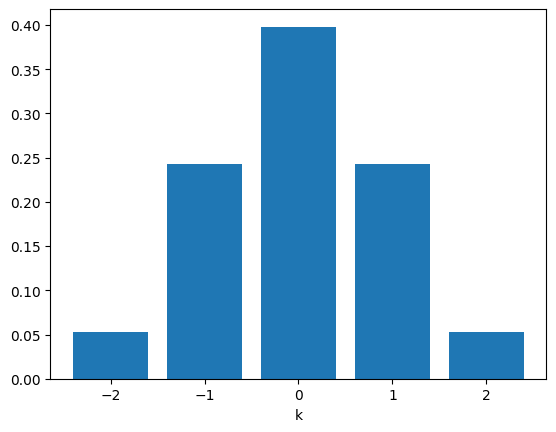

<BarContainer object of 8 artists>

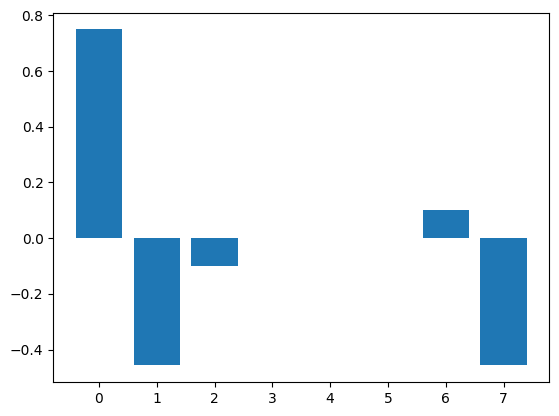

In [37]:
print(np.real(cs))
print(np.real(psi))
plt.bar(ks, np.real(cs))
plt.xlabel("k")
plt.show()

plt.bar(np.arange(len(psi)), np.real(psi))